# Acquiring Data From BigQuery #

In [93]:
from google.cloud import bigquery
client = bigquery.Client()

QUERY = """
        SELECT repo_name, language
        FROM `bigquery-public-data.github_repos.languages`
        LIMIT 50000
        """

query_job = client.query(QUERY)

iterator = query_job.result(timeout=30)
rows = list(iterator)

for i in range(10):
    for j in rows[i].language:
        print j[u'name']
    print 

C
D

C
D

C
D
Java
JavaScript
OCaml
PHP
Perl
Python
Shell

C
D
Shell

C
D
Shell
XML

C
D
DTrace
Fortran
Go
Julia
Makefile
Python
Rust
Scala
Scheme

C
D
Python
Shell

C
D
JavaScript
PHP
Perl
Python
Shell

C
D
JavaScript
PHP
Perl
Python
Shell

C
D
JavaScript
OCaml
PHP
Perl
Python
Shell



# List of Languages #

In [94]:
#sourced from githut 
import pandas

df = pandas.read_csv('data/language_names.csv')
names = df['language_name'].tolist()

name_to_index = {}
for j,i in enumerate(names):
    name_to_index[i] = j

# Repository-Language Matrix #

In [95]:
import numpy as np
from math import log

mat = np.zeros((len(rows),len(names)))
for i,row in enumerate(rows):
    total = sum([log(lang[u'bytes']) if lang[u'bytes']!=0 else 0 for lang in row[1]])
    for lang in rows[i].language:
        mat[i][name_to_index[lang[u'name']]] = (log(lang[u'bytes']) if lang[u'bytes']!=0 else 0)/total if total!=0 else 0

# K-Means #

In [96]:
from sklearn.cluster import KMeans

n_clusters = 5
km = KMeans(n_clusters=n_clusters)
km.fit(mat)
print km.labels_
print km.cluster_centers_

[0 0 2 ..., 3 2 2]
[[ 0.00744025  0.00463076  0.00753814 ...,  0.          0.          0.        ]
 [ 0.13377601  0.20902048  0.08283575 ...,  0.          0.          0.        ]
 [ 0.00947829  0.01293706  0.03859889 ...,  0.          0.          0.        ]
 [ 0.26464879  0.16465005  0.14825927 ...,  0.          0.          0.        ]
 [ 0.04384297  0.05335626  0.06944589 ...,  0.          0.          0.        ]]


# PCA #

In [97]:
from sklearn.decomposition import PCA

#not good enough for visualization
pca = PCA(n_components=2)
transformed = pca.fit_transform(mat[:,:10]) 
print sum(pca.explained_variance_ratio_)
print pca.singular_values_

0.328067710982
[ 41.95844708  32.73383163]


# PCA Visualization #

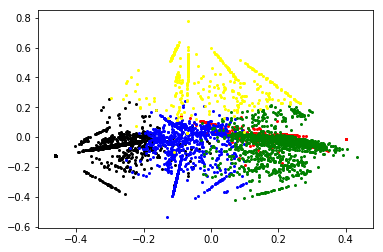

In [109]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib inline

colors = ['black','red','blue','green','yellow','purple','pink','orange','gray','brown']
clusters = []
transformed = np.concatenate((transformed,np.reshape(np.array(km.labels_),(-1,1))),1)
for i in range(n_clusters):
    cluster = transformed[transformed[:,2]==i]
    clusters.append(cluster)
    smpl = np.asarray(random.sample(cluster,np.shape(cluster)[0]/10))
    plt.scatter(smpl[:,0],smpl[:,1],color=colors[i],s=4)

# Languages by Cluster #

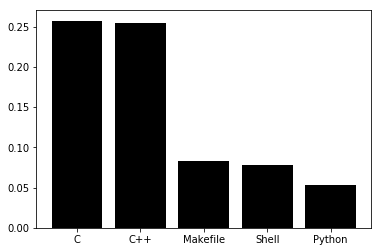

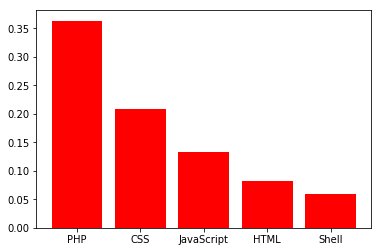

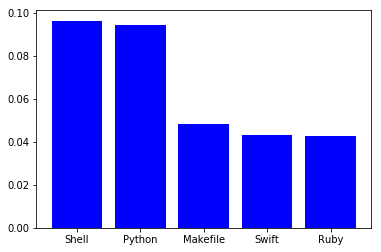

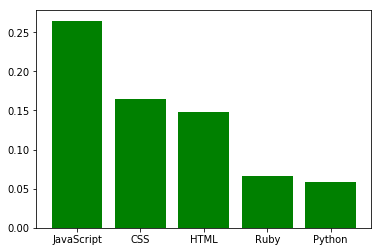

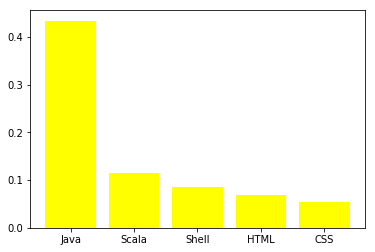

In [107]:
plt.ioff()
for i,ctr in enumerate(km.cluster_centers_.tolist()):
    langs = sorted([(val,names[j]) for j,val in enumerate(ctr)],reverse=True)
    X = ['']
    X.extend([langs[k][1] for k in range(5)])
    Y = [langs[k][0] for k in range(5)]
    
    fig = plt.figure()
    plt.bar(range(1,6),Y,color=colors[i])
    ax = plt.gca()
    ax.set_xticklabels(X)

# Language Associations #